In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42

In [2]:
ruta = r"C:\Users\analista.datos\Documents\Universidad\Machine learning\miniproyecto_s10\data\cleaned\heart_cleaned.csv"
df = pd.read_csv(ruta)

# --- Variable objetivo ---
y = df["HeartDisease"]
X = df.drop(columns=["HeartDisease"])

# --- Identificar tipos de variables ---
num_cols = X.select_dtypes(include=["number"]).columns
cat_cols = X.select_dtypes(exclude=["number"]).columns

# --- División de datos antes del escalado (sin fuga) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Train: (734, 11), Test: (184, 11)


In [3]:
# --- Preprocesamiento (escalado + OneHot) ---
preprocess = ColumnTransformer(transformers=[
    ('num', RobustScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


In [4]:
def train_pipeline(X_train, y_train, model, param_grid, model_name):
    """
    Entrena un modelo usando Pipeline + GridSearchCV con validación estratificada.
    Retorna el modelo entrenado, mejores parámetros y AUC promedio.
    """
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", model)])

    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )

    print(f"\nEntrenando {model_name}...")
    grid.fit(X_train, y_train)
    print(f"Mejor AUC (CV): {grid.best_score_:.4f}")
    print("Mejores parámetros:", grid.best_params_)

    return grid


In [5]:
models = {
    "LogisticRegression": {
        "estimator": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        "params": {
            "model__penalty": ["l2"],
            "model__C": [0.1, 1, 10],
            "model__solver": ["lbfgs", "liblinear"]
        }
    },
    "RandomForest": {
        "estimator": RandomForestClassifier(random_state=RANDOM_STATE),
        "params": {
            "model__n_estimators": [200, 400],
            "model__max_depth": [None, 10, 20],
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "KNN": {
        "estimator": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": [3, 5, 7],
            "model__weights": ["uniform", "distance"]
        }
    },
    "GradientBoosting": {
        "estimator": GradientBoostingClassifier(random_state=RANDOM_STATE),
        "params": {
            "model__n_estimators": [100, 300],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [2, 3]
        }
    },
    "SVC": {
        "estimator": SVC(probability=True, random_state=RANDOM_STATE),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__gamma": [0.01, 0.1, 1]
        }
    }
}



Entrenando LogisticRegression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejor AUC (CV): 0.9226
Mejores parámetros: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


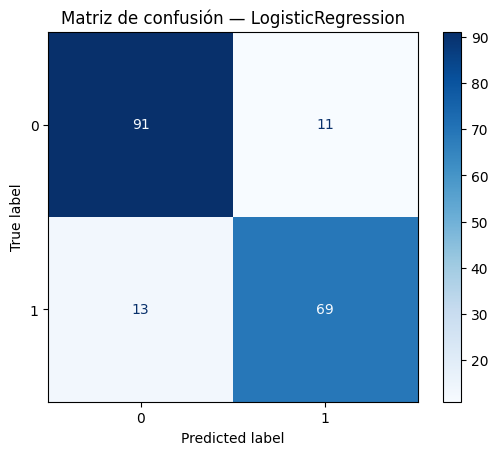

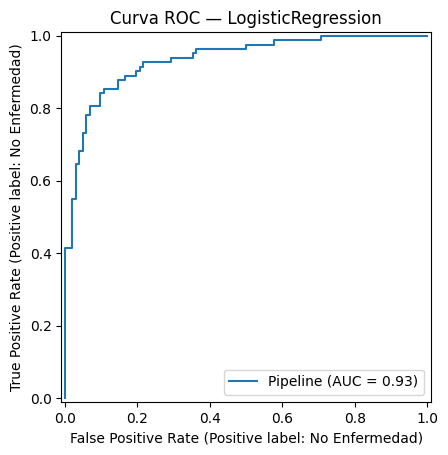


Entrenando RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejor AUC (CV): 0.9247
Mejores parámetros: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__n_estimators': 400}


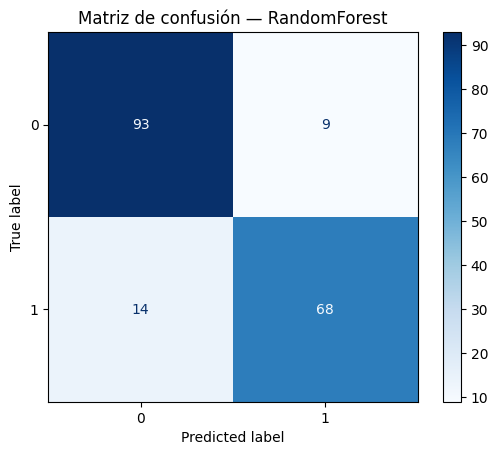

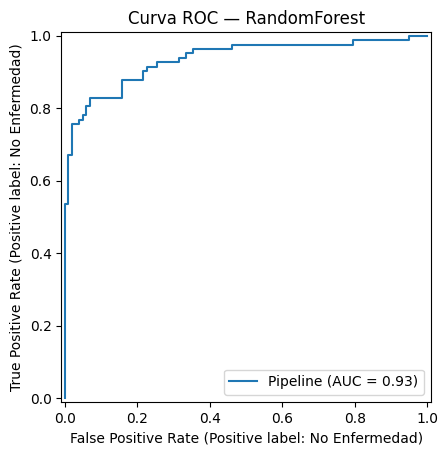


Entrenando KNN...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejor AUC (CV): 0.9074
Mejores parámetros: {'model__n_neighbors': 7, 'model__weights': 'distance'}


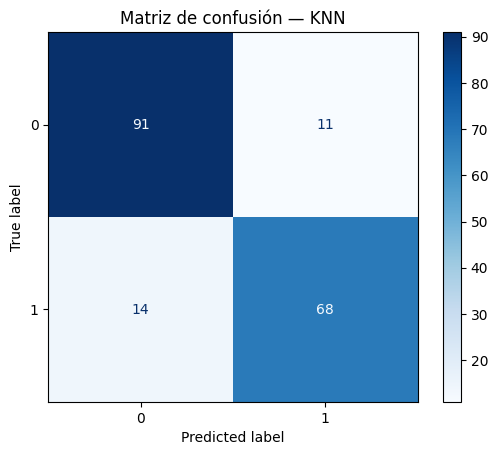

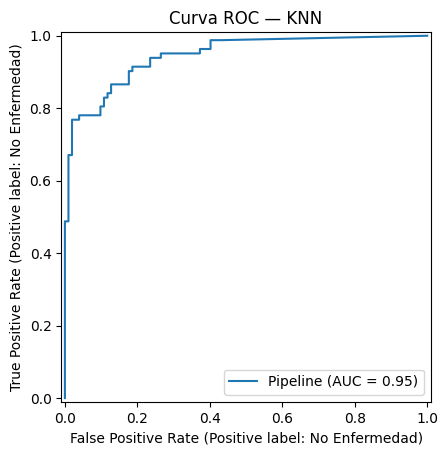


Entrenando GradientBoosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejor AUC (CV): 0.9242
Mejores parámetros: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}


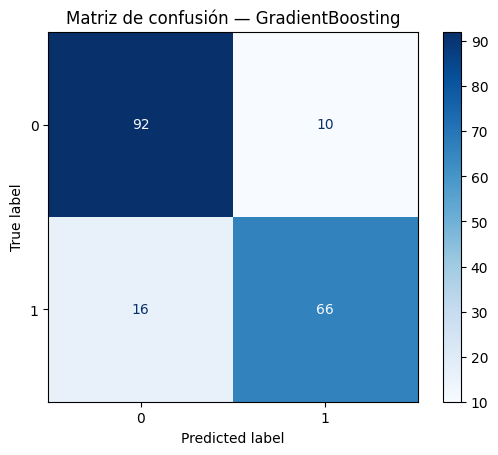

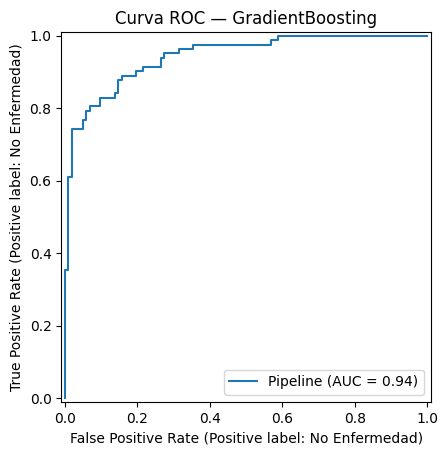


Entrenando SVC...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejor AUC (CV): 0.9256
Mejores parámetros: {'model__C': 1, 'model__gamma': 0.1}


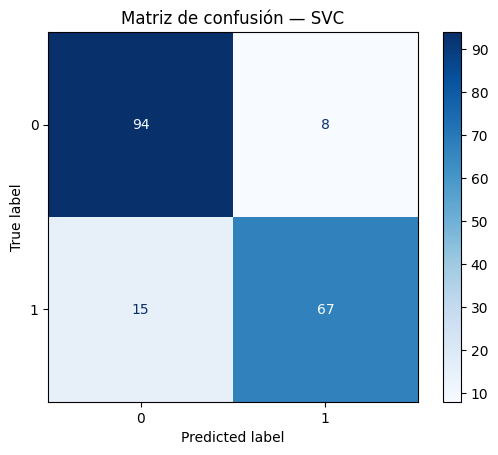

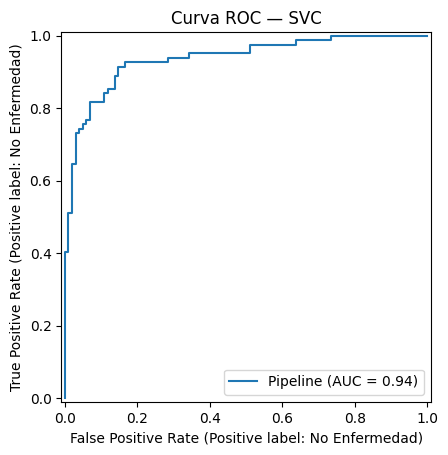

In [6]:
results = []

for name, cfg in models.items():
    grid = train_pipeline(X_train, y_train, cfg["estimator"], cfg["params"], name)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        "Modelo": name,
        "AUC_CV": grid.best_score_,
        "AUC_Test": auc,
        "Accuracy": acc,
        "Best_Params": grid.best_params_
    })

    # Visualización básica
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues")
    plt.title(f"Matriz de confusión — {name}")
    plt.show()

    RocCurveDisplay.from_estimator(best_model, X_test, y_test)
    plt.title(f"Curva ROC — {name}")
    plt.show()


In [7]:
results_df = pd.DataFrame(results).sort_values(by="AUC_Test", ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


,Modelo,AUC_CV,AUC_Test,Accuracy,Best_Params
0,KNN,0.907407,0.945481,0.864130,"{'model__n_neighbors': 7, 'model__weights': 'd..."
1,GradientBoosting,0.924241,0.942970,0.858696,"{'model__learning_rate': 0.05, 'model__max_dep..."
2,SVC,0.925643,0.937111,0.875000,"{'model__C': 1, 'model__gamma': 0.1}"
3,RandomForest,0.924681,0.934959,0.875000,"{'model__max_depth': 10, 'model__max_features'..."
4,LogisticRegression,0.922600,0.934003,0.869565,"{'model__C': 0.1, 'model__penalty': 'l2', 'mod..."
